In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import os

# --- 1. Ayarlar ve Hiperparametreler ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

# Klasör yoksa oluştur (Sonuçları kaydetmek için)
os.makedirs("gan_sonuclari", exist_ok=True)

# Hiperparametreler
latent_dim = 100    # Gürültü vektörünün boyutu
lr = 0.0002         # Öğrenme oranı (GAN'lar için genelde düşük seçilir)
batch_size = 64
n_epochs = 10      # Toplam eğitim turu
sample_interval = 2 # Kaç epoch'ta bir görüntü kaydedilecek?

# --- 2. Veri Hazırlığı ---
# GAN'larda genellikle Tanh aktivasyonu kullanıldığı için veriyi [-1, 1] arasına normalize ederiz.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # (X - 0.5) / 0.5 -> [0, 1] aralığını [-1, 1] yapar
])

dataloader = DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

# --- 3. Model Mimarileri ---

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Gürültü Vektörü -> Görüntü (Flatten edilmiş: 784 piksel)
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2, inplace=True), # GAN'larda LeakyReLU daha stabil sonuç verir
            nn.BatchNorm1d(256),             # Eğitimi hızlandırır
            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),
            
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(1024),
            
            nn.Linear(1024, 28 * 28), # 784 piksel
            nn.Tanh() # Çıktıyı [-1, 1] arasına sıkıştırır
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28) # (Batch, 1, 28, 28) formatına getir
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # Görüntü -> Olasılık (Gerçek mi Sahte mi?)
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(256, 1),
            nn.Sigmoid() # Olasılık için [0, 1] arasına sıkıştırır
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) # Görüntüyü düzleştir
        validity = self.model(img_flat)
        return validity

# Modelleri başlat
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Kayıp Fonksiyonu ve Optimizerlar
adversarial_loss = nn.BCELoss() # Binary Cross Entropy

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# --- 4. Eğitim Döngüsü ---
print("GAN Eğitimi Başlıyor...")

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        
        # Gerçek görüntüleri al
        real_imgs = imgs.to(device)
        
        # Etiketler (1: Gerçek, 0: Sahte)
        valid = torch.ones(imgs.size(0), 1, device=device, requires_grad=False)
        fake = torch.zeros(imgs.size(0), 1, device=device, requires_grad=False)

        # -----------------
        #  Generator Eğitimi
        # -----------------
        optimizer_G.zero_grad()

        # Rastgele gürültü üret
        z = torch.randn(imgs.size(0), latent_dim, device=device)

        # Sahte görüntü üret
        gen_imgs = generator(z)

        # Generator'ın amacı: Discriminator'ın bu görüntülere "Gerçek (1)" demesini sağlamak
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Discriminator Eğitimi
        # ---------------------
        optimizer_D.zero_grad()

        # Gerçek resim kaybı (Bunlara 1 demeli)
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        
        # Sahte resim kaybı (Bunlara 0 demeli)
        # .detach() kullanıyoruz çünkü G'yi eğitmek istemiyoruz, sadece D'yi eğitiyoruz.
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    # --- Durum Raporu ve Kayıt ---
    print(f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    # Belirli aralıklarla örnek resimler kaydet
    if (epoch + 1) % sample_interval == 0:
        with torch.no_grad():
            # Sabit bir gürültü ile üretelim ki gelişimi görelim (opsiyonel)
            sample_z = torch.randn(25, latent_dim, device=device)
            gen_imgs = generator(sample_z)
            
            # Görüntüleri kaydet
            save_path = f"gan_sonuclari/epoch_{epoch+1}.png"
            save_image(gen_imgs.data[:25], save_path, nrow=5, normalize=True)
            print(f"   -> Görüntüler kaydedildi: {save_path}")

print("Eğitim Tamamlandı.")

Kullanılan Cihaz: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 59.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.67MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.42MB/s]


GAN Eğitimi Başlıyor...
[Epoch 1/10] [D loss: 0.6222] [G loss: 0.6703]
[Epoch 2/10] [D loss: 0.5981] [G loss: 0.7422]
[Epoch 3/10] [D loss: 0.5969] [G loss: 0.9356]
[Epoch 4/10] [D loss: 0.6624] [G loss: 0.9221]
[Epoch 5/10] [D loss: 0.6296] [G loss: 0.5947]
   -> Görüntüler kaydedildi: gan_sonuclari/epoch_5.png
[Epoch 6/10] [D loss: 0.6072] [G loss: 0.8951]
[Epoch 7/10] [D loss: 0.6334] [G loss: 0.7932]
[Epoch 8/10] [D loss: 0.5972] [G loss: 0.7039]
[Epoch 9/10] [D loss: 0.6676] [G loss: 1.2907]
[Epoch 10/10] [D loss: 0.6851] [G loss: 0.7116]
   -> Görüntüler kaydedildi: gan_sonuclari/epoch_10.png
Eğitim Tamamlandı.


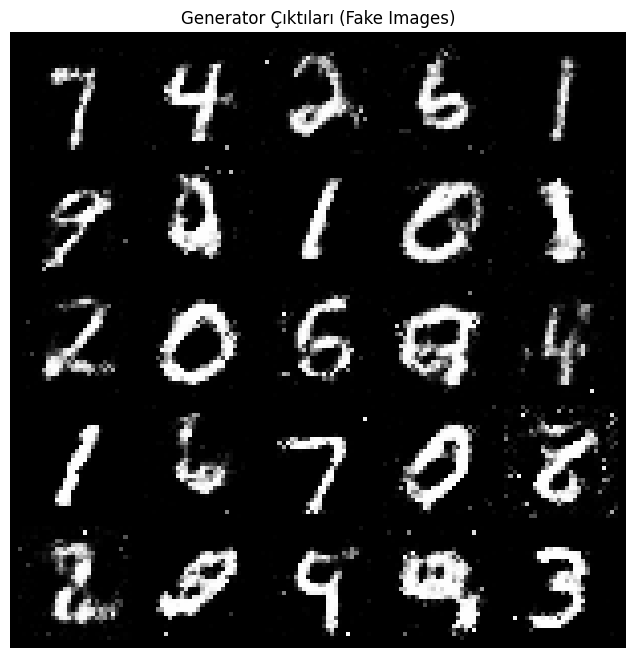

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import torch

# 1. Tensörü görselleştirilebilir formata sokma fonksiyonu
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Girdi: image_tensor (Görüntülerin olduğu batch)
    Çıktı: Ekrana çizilmiş grid
    '''
    # a. Tensörü kopyala, CPU'ya al ve gradyan takibini kes (detach)
    image_tensor = image_tensor.detach().cpu()
    
    # b. Grid oluştur (make_grid otomatik olarak yan yana dizer)
    # nrow=5: Her satırda 5 resim olsun (5x5 grid için)
    # normalize=True: Tanh çıktısı olan [-1, 1] değerlerini [0, 1] aralığına çeker (Çok Önemli!)
    image_grid = make_grid(image_tensor[:num_images], nrow=5, normalize=True)
    
    # c. Matplotlib formatına çevir: (C, H, W) -> (H, W, C)
    # PyTorch kanalı başta tutar, Matplotlib sonda ister.
    plt.figure(figsize=(8, 8))
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.title("Generator Çıktıları (Fake Images)")
    plt.show()


sample_z = torch.randn(25, latent_dim, device=device)
gen_imgs = generator(sample_z)

# --- GÖRSELLEŞTİRME ---
show_tensor_images(gen_imgs)